# Project 5 Vehicle Detection

**Author: olala7846@gmail.com**

## Step 1: train a image vehicle classifier

In [1]:
# first do some training data observation
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random


vehicle_imgs = list(glob.glob('./vehicles/**/*.png'))
nonvehicle_imgs = list(glob.glob('./non-vehicles/**/*.png'))

print('Total %d vehicle images' % len(vehicle_imgs))
print('Total %d non-vehicle images' % len(nonvehicle_imgs))
print('There are about the same size of both classes')

sample_img = random.sample(vehicle_imgs, 1)[0]
img = cv2.imread(sample_img)
print('images has shape', img.shape, 'and dtype', img.dtype)
print('Pixel value range approximately from', np.max(img), 'to', np.min(img))

Total 8792 vehicle images
Total 8968 non-vehicle images
There are about the same size of both classes
images has shape (64, 64, 3) and dtype uint8
Pixel value range approximately from 255 to 2


In [2]:
# Explore different color space
from mpl_toolkits.mplot3d import Axes3D

def plot3d(car_pixels, non_car_pixels):
    """Plot pixels in 3D"""
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    
    all_pixels = np.vstack((car_pixels, non_car_pixels))

    # Set axis limits
    ax.set_xlim(np.min(all_pixels[:, 0]), np.max(all_pixels[:, 0]))
    ax.set_ylim(np.min(all_pixels[:, 1]), np.max(all_pixels[:, 1]))
    ax.set_zlim(np.min(all_pixels[:, 2]), np.max(all_pixels[:, 2]))

    ax.scatter(
        car_pixels[:, 0].ravel(),
        car_pixels[:, 1].ravel(),
        car_pixels[:, 2].ravel(),
        c='g', edgecolors='none')

    ax.scatter(
        non_car_pixels[:, 0].ravel(),
        non_car_pixels[:, 1].ravel(),
        non_car_pixels[:, 2].ravel(),
        c='r', edgecolors='none')
    
    return ax

def observe_colorspace():
    sample_car_imgs = random.sample(vehicle_imgs, 100)
    sample_noncar_imgs = random.sample(nonvehicle_imgs, 100)

    convertors = {
        'RGB': cv2.COLOR_BGR2RGB,
        'HLS': cv2.COLOR_BGR2HLS,
        'YUV': cv2.COLOR_BGR2YUV,
        'YCrCb': cv2.COLOR_BGR2YCrCb,
        'Lab': cv2.COLOR_BGR2Lab,
        'Luv': cv2.COLOR_BGR2Luv,
    }

    for name, convertor in convertors.items():
        car_pixels = []
        noncar_pixels = []

        samples_per_pic = 10

        for car_img in sample_car_imgs:
            img = cv2.imread(car_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            car_pixels.append(sample_pixels)

        for noncar_img in sample_noncar_imgs:
            img = cv2.imread(noncar_img)
            img = cv2.cvtColor(img, convertor)
            pixels = np.reshape(img, (-1, 3))
            sample_pixels = random.sample(list(pixels), samples_per_pic)
            noncar_pixels.append(sample_pixels)

        car_pixels = np.vstack(car_pixels)
        noncar_pixels = np.vstack(noncar_pixels)

        ax = plot3d(car_pixels, noncar_pixels)
        plt.title(name)
#        # plot different view points
#         for ii in range(0,360,5):
#             ax.view_init(elev=10., azim=ii)
#             plt.savefig("./color_spaces/%s%d.png" % (name, ii))
        
        
#observe_colorspace()

### Color space
After tested on mandy color spaces, it's easy to see that some (e.g. RGB, HLS) does a better job seperating vehicle and non-vehicle images. I will choose HLS as the color space for histogram of color.

reading  ./vehicles/GTI_Far/image0000.png


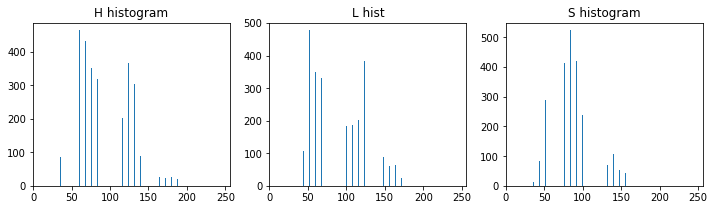

In [3]:
# Extact color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256), color_space='RGB', visualize=False):
    convertors = {
        'RGB': cv2.COLOR_BGR2RGB,
        'HLS': cv2.COLOR_BGR2HLS,
        'YUV': cv2.COLOR_BGR2YUV,
        'YCrCb': cv2.COLOR_BGR2YCrCb,
        'Lab': cv2.COLOR_BGR2Lab,
        'Luv': cv2.COLOR_BGR2Luv,
    }
    convertor = convertors[color_space]
    img = cv2.cvtColor(img, convertor)
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    if visualize:
        return hist0, hist1, hist2
    else:
        return np.concatenate((hist0[0], hist1[0], hist2[0]))
    
img_name = vehicle_imgs[0]
print('reading ', img_name)
img = cv2.imread(vehicle_imgs[0])
hist1, hist2, hist3 = color_hist(img, color_space='RGB', visualize=True)

# visualize histogram
bin_edges = hist1[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, hist1[0])
plt.xlim(0, 256)
plt.title('H histogram')
plt.subplot(132)
plt.bar(bin_centers, hist2[0])
plt.xlim(0, 256)
plt.title('L hist')
plt.subplot(133)
plt.bar(bin_centers, hist3[0])
plt.xlim(0, 256)
plt.title('S histogram')
plt.show()

In [4]:
# Spatial bin
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    convertors = {
        'RGB': cv2.COLOR_BGR2RGB,
        'HLS': cv2.COLOR_BGR2HLS,
        'YUV': cv2.COLOR_BGR2YUV,
        'YCrCb': cv2.COLOR_BGR2YCrCb,
        'Lab': cv2.COLOR_BGR2Lab,
        'Luv': cv2.COLOR_BGR2Luv,
    }
    convertor = convertors[color_space]
    feature_img = cv2.cvtColor(img, convertor)
    features = cv2.resize(feature_img, size).ravel()
    return features


In [5]:
# Prepare training data
from sklearn.preprocessing import StandardScaler

def extract_features(img, color_space='Luv'):
    img = cv2.imread(img)
    color_hist_features = color_hist(img, color_space='Luv')
    bin_spatial_features = bin_spatial(img, color_space='RGB')
    return np.concatenate((color_hist_features, bin_spatial_features))


car_features = np.array([extract_features(img) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img) for img in nonvehicle_imgs])

# define labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))

print(X.shape, y.shape)

(17760, 3168) (17760,)


In [6]:
# train classifier with SVM
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.959459459459


## Some experiment on color spaces
| Color space | Accuracy | Accuracy Only using color hist | Accuracy only using spatial bin |
|-------------|----------|--------------------------------|---------------------------------|
| RGB         | 0.9535   | 0.911599                       | 0.916666                        |
| HLS         | 0.94     | 0.9442567                      | 0.878378                        |
| YUV         | 0.95326  | 0.91019                        | 0.900619                        |
| YCrCb       | 0.9493   | 0.920608                       | 0.90625                         |
| Lab         | 0.95777  | 0.94284                        | 0.904560                        |
| Luv         | 0.94876  | 0.948761                       | 0.907094                        |

## Classifier
We get 0.9538 accuracy only using color features!
|---


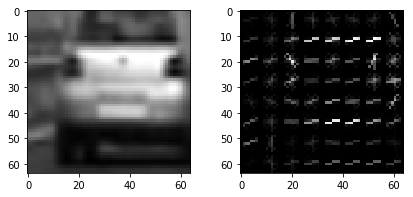

In [7]:
# hog features
from skimage.feature import hog

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)


img = cv2.imread(vehicle_imgs[100])
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, vis=True)
fig = plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.show()

In [15]:
# HOG feature extraction
def extract_features(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y_features = get_hog_features(img[:,:,0])
    Cr_features = get_hog_features(img[:,:,1])
    Cb_features = get_hog_features(img[:,:,2])
    features = np.concatenate((Y_features, Cr_features, Cb_features))
    return features.ravel()

car_features = np.array([extract_features(img) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img) for img in nonvehicle_imgs])

# define labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))

print(X.shape, y.shape)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

(17760, 5292) (17760,)
Test Accuracy of SVC =  0.988738738739


## Some experiment on HOG features
| Color space | Accuracy |
|-------------|----------|
| Gray        | 0.9555   |
| H(HLS)      | 0.9203   |
| L(HLS)      | 0.9484   |
| S(HLS)      | 0.9031   |
| Y(YUV)      | 0.9527   |
| U(YUV)      | 0.9304   |
| V(YUV)      | 0.9020   |
| Y(YCrCb)    | 0.9518   |
| Cr(YCrCb)   | 0.9256   |
| Cb(YCrCb)   | 0.9090   |
| YCrCb(All)  | 0.9887   |


In [17]:
# feature selection
from sklearn.feature_selection import SelectFromModel
import time


def extract_features(img, color_space='Luv'):
    img = cv2.imread(img)
    color_hist_features = color_hist(img, color_space='Luv')
    bin_spatial_features = bin_spatial(img, color_space='RGB')
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y_features = get_hog_features(img[:,:,0]).ravel()
    Cr_features = get_hog_features(img[:,:,1]).ravel()
    Cb_features = get_hog_features(img[:,:,2]).ravel()
    return np.concatenate((color_hist_features, bin_spatial_features, Y_features, Cr_features, Cb_features))

car_features = np.array([extract_features(img) for img in vehicle_imgs])
noncar_features= np.array([extract_features(img) for img in nonvehicle_imgs])

# define labels
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(noncar_features))))
print(X.shape, y.shape)

(17760, 8460) (17760,)


In [19]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

kernel = 'linear'

t = time.time()
svc1 = SVC(kernel=kernel)
svc1.fit(X_train, y_train)
t2 = time.time()
print('Test Accuracy of SVC1 = ', svc1.score(X_test, y_test))
t3 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t3-t2, 2), 'Seconds to score SVC...')

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

print('Feature selection with decision tree')
feature_select = SelectFromModel(tree_clf, prefit=True)
X_train_new = feature_select.transform(X_train)
X_test_new = feature_select.transform(X_test)
print(X_train.shape)
print(X_train_new.shape)

t = time.time()
svc2 = SVC(kernel=kernel)
svc2.fit(X_train_new, y_train)
t2 = time.time()
print('Test Accuracy of SVC2 = ', svc2.score(X_test_new, y_test))
t3 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC2...')
print(round(t3-t2, 2), 'Seconds to score SVC...')

Test Accuracy of SVC1 =  0.990427927928
117.82 Seconds to train SVC...
28.15 Seconds to score SVC...
(14208, 8460)
(14208, 139)
Test Accuracy of SVC2 =  0.97972972973
9.71 Seconds to train SVC2...
0.31 Seconds to score SVC...


In [20]:
import pickle
data = {
    'feature_select': feature_select,
    'classifier': svc2,
}
filename = 'classifier.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data, f)

## Feature selection using devision tree
from 8460 features to 139 features

In [ ]:

# Feature extraction
# TODO(Olala)
# 1. observe data
# 2. extract features
#     2.1 histogram on color space
#     2.2 HOG features
# 3. train classifier
#     3.1 train test split
#     3.2 test on different classifier parameters
#     3.3 choose the best
# 4. sliding window search
#     4.1 sliding window with HOG features
#     4.2 different sliding window size
#     4.3 reduce false positive using heatmap
# 5. run pipeline on video
#     5.1 create detection pipeline
#     5.2 reduce false positive using series of frames
# 6. write report

